In [1]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from model import predict # Функция, позволяет получить предсказание нейронки.
from check_budget import check_budget # функция проверки бюджета. Проверяйте допустимость решения до сабмита
from sklearn.metrics import roc_auc_score

In [2]:
bins_path = "nn_bins.pickle" # путь до файла с бинами после тренировки модели (nn_bins.pickle)
model_path = "nn_weights.ckpt" # путь до файла с весами нейронной сети (nn_weights.ckpt)
quantiles_path = "quantiles.json" # путь до файла с квантилями для таргета (quantiles.pickle)
BUDGET = 10 # разрешенное количество изменений транзакций для каждого пользователя

output_path = "naive_submission.csv" # куда сохранить атакованные транзакции
transactions_path = "../sample_submission.csv"    # путь до файла с транзакциями, которые атакуются

train_data_path = "../transactions_finetune.csv" # X - train data
train_target_path = "../target_finetune.csv" # y - true target

In [3]:
# у нас нет разметки для тех транзакций, которые мы атакуем - но у нас есть модель.
# Давайте посчитаем вероятность того, что пользователь принадлежит к классу 1
result = predict(transactions_path, bins_path, model_path, random_seed=20230206)
result.head()

Global seed set to 20230206


,user_id,target
0,66,0.035652
1,213,0.031230
2,345,0.182279
3,569,0.090401
4,573,0.011963


In [500]:
result.target.max()/2

0.1805008500814438

In [5]:
# давайте в качестве порога использовать середину этого диапазона
# все что выше - пусть будет предсказано 1, что ниже - 0
threshold = result.target.max() / 2

In [6]:
result.target.max()

0.3610017001628876

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [7]:
# Найдем пользователя, для которого нейронка предсказала самое большое значение таргета.
# Это будет наш Герой, Образцовый Положительный Пользователь
hero_user = result.user_id.loc[result.target.argmax()]
hero_user

829187

In [8]:
result.target.min()

0.0005157093983143568

In [9]:
# Найдем так пользователя с самым низким таргетом
# Это будет наш Неудачник
poor_user = result.user_id.loc[result.target.argmin()]
poor_user

488752

In [10]:
# границы допустимых решений.

with open(quantiles_path, 'r') as f:
    quantiles = json.load(f)

In [11]:
# для каждого кода заданы лимиты положительных и отрифательных значений
# Вот, например, диапазон, в котором должны лежать суммы для ьcc_code 4111
quantiles["positive"]["min"]["4111"], quantiles["positive"]["max"]["4111"]

(8.145073890686035, 45117.69001)

In [12]:
# Читаем файл с исходными транзакциями
df_transactions = (
    pd.read_csv(
        transactions_path,
        parse_dates=["transaction_dttm"],
        dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
    )
)

In [13]:
df_transactions.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,66,5812,48,-1842.949000,2021-05-17 11:30:42
1,66,4112,48,-283.283720,2021-05-17 12:59:02
2,66,5814,48,-73.820390,2021-05-17 14:04:09
3,66,4111,48,10.971557,2021-05-17 15:03:10
4,66,7991,48,-214.796420,2021-05-17 15:33:43


In [14]:
# уникальные id и кол-во транзакций
pd.DataFrame(df_transactions.user_id.value_counts().reset_index().values,
             columns=['user_id', 'transactions_count'])

,user_id,transactions_count
0,66,300
1,571077,300
2,571331,300
3,571395,300
4,571406,300
...,...,...
4195,290206,300
4196,290445,300
4197,290463,300
4198,290532,300


In [15]:
# уникальные mcc коды и кол-во транзакций
pd.DataFrame(df_transactions.mcc_code.value_counts().reset_index().values,
             columns=['mcc_code', 'transactions_count'])

,mcc_code,transactions_count
0,5411,364313
1,5499,112763
2,6011,101284
3,5814,86973
4,5541,50243
...,...,...
291,3640,1
292,3692,1
293,4119,1
294,7012,1


In [16]:
# уникальные валюты транзакций и кол-во транзакций
pd.DataFrame(df_transactions.currency_rk.value_counts().reset_index().values,
             columns=['currency_rk', 'transactions_count'])
# 48 RUB
# 50 USD
# 60 EUR

,currency_rk,transactions_count
0,48,1257737
1,50,1697
2,60,566


In [17]:
# описание mcc кодов
df_info_mcc = pd.read_csv('../info/mcc_codes.csv')
df_info_mcc.head()

,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."
2,780,Услуги садоводства и ландшафтного дизайна,Ландшафтные архитекторы и другие поставщики ус...
3,1520,Генеральные подрядчики – жилое и коммерческое ...,"Генеральные подрядчики, в основном занимающиес..."
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Специальные торговые подрядчики, которые работ..."


In [18]:
df_info_mcc.loc[df_info_mcc['MCC'] == 5411]

,MCC,Название,Описание
170,5411,"Бакалейные магазины, супермаркеты","Торговые точки, которые продают полную линейку..."


In [19]:
df_info_mcc.iloc[170]['Описание']

'Торговые точки, которые продают полную линейку продуктов питания для домашнего потребления. Пищевые продукты для продажи включают бакалейные товары, мясо, продукты, молочные продукты и консервированные, замороженные, предварительно упакованные и сухие продукты. Также продукты для продажи могут включать ограниченный выбор посуды, чистящих и полирующих изделий, средств личной гигиены, косметики, поздравительных открыток, книг, журналов, предметов домашнего обихода и сухих товаров. Эти точки также могут управлять специализированными отделами, такими как лавка деликатесов, мясная лавка, аптека или цветочный отдел.\nДля магазинов, которые продают ограниченный выбор продуктов или предметов специальности, используется MCC 5499.'

In [20]:
result

,user_id,target
0,66,0.035652
1,213,0.031230
2,345,0.182279
3,569,0.090401
4,573,0.011963
...,...,...
4195,868183,0.024825
4196,868407,0.054975
4197,868573,0.040958
4198,868694,0.017257


[Text(0.5, 1.0, 'Гистограмма предсказанного таргета')]

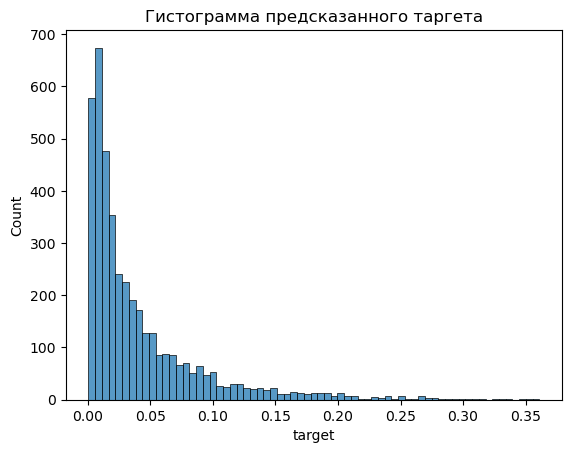

In [21]:
import seaborn as sns

sns.histplot(data=result, x="target").set(title='Гистограмма предсказанного таргета')

In [22]:
# индексы пользователей с mcc_code, который равен -1 (нет описания)
mcc_code_error = df_transactions.loc[(df_transactions.mcc_code == -1)].user_id.value_counts().index.values
mcc_code_error

array([432660, 582247, 146633, 416334, 615318, 163596, 759693, 738059,
       188401, 263827, 517600, 606531, 251754, 437787, 155663, 413130,
       292809,  87422, 326129, 796741, 511383, 693603, 230179, 854175,
       646467, 362692, 665619, 734130, 828998, 222540, 359134, 562056,
       231596, 850101, 326791, 285107, 515059, 631877, 775817, 322513,
       444440, 344557, 636641, 670699, 360677, 192146, 549115, 486394,
       816881, 835487, 411962, 658642, 386530, 133386, 683646, 487708,
        16336, 508324, 603700, 799715, 795819, 780991, 338589,   6504,
       320760, 477595, 656702,    573, 716199, 277488, 644130,  64106,
        90827, 395620, 675880, 136851, 186750, 151094, 558808, 608724,
       274151, 278563, 190167, 599873, 247186, 607397, 128464, 828227,
       533812, 171808, 392990, 146751, 809017, 475142, 697751, 618397,
       354963, 120435, 501459, 456230, 840564, 253005, 732516, 576465,
         9986, 859217, 788293,  50396, 616304, 723808,  43567, 739804,
      

In [23]:
# кол-во транзакций у mcc кода -1 для id 573
df_transactions.loc[(df_transactions.user_id == 573) & (df_transactions.mcc_code == -1)].user_id.value_counts()

573    27
Name: user_id, dtype: int64

In [24]:
# таргеты для id, в которых есть mcc код -1
result[result["user_id"].isin(mcc_code_error)]

,user_id,target
4,573,0.011963
18,3966,0.111619
30,6504,0.011335
40,9986,0.012918
73,16336,0.011196
...,...,...
4113,851981,0.004525
4124,854175,0.034197
4144,858044,0.001292
4154,859217,0.077555


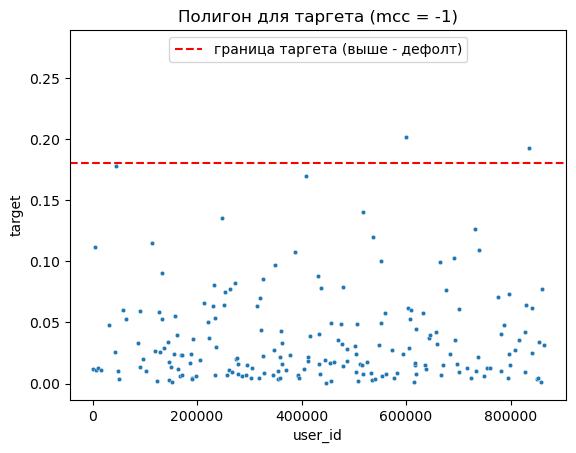

In [25]:
import matplotlib.pyplot as plt

sns.scatterplot(data=result[result["user_id"].isin(mcc_code_error)], x="user_id", y="target", s=10).set(
    title='Полигон для таргета (mcc = -1)')
plt.axhline(y=result.target.max()/2, color='r', linestyle='--', label="граница таргета (выше - дефолт)")
plt.legend(loc='upper center')

In [26]:
# диапазон для самого популярного mcc
quantiles["positive"]["min"]["5411"], quantiles["positive"]["max"]["5411"]

(0.90168, 36819.70001)

In [27]:
# диапазон для mcc -1 (ВСЕ ТРАНЗАКЦИИ ДЛЯ ЭТОГО КОДА ЯВЛЯЮТСЯ 48 - RUB)
quantiles["positive"]["min"]["-1"], quantiles["positive"]["max"]["-1"]

(0.85339, 333111.0625)

In [28]:
# one_idx = result.index[result.target > threshold]  # Эти пользователи похожи на Героя
# zero_idx = result.index[result.target <= threshold] # А эти на Неудачника

# users = result.user_id.values

# one_users = users[one_idx] # defolt - 1
# zero_users = users[zero_idx] # norm users - 0

# for user in users[:2]: # count users = 2
#     if user in one_users:
#         copy_from = poor_user # похожим на Героя скопируем 10 последних транзакций Неудачника
#     else:
#         copy_from = hero_user # А похожим на Неудачника наоборот
#     print(copy_from)

#     idx_to = df_transactions.index[df_transactions.user_id == user][-BUDGET:]
#     idx_from = df_transactions.index[df_transactions.user_id == copy_from][-BUDGET:]

#     sign_to = np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)
#     sign_from = np.sign(df_transactions.loc[idx_from, "transaction_amt"].values)
#     sign_mask = (sign_to == sign_from)

In [29]:
random.seed(20230206)

# threshold = pd.read_csv("../data/target_finetune.csv").target.mean()  # вероятность, по которой мы считаем таргет

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)

bins_path = "nn_bins.pickle"
model_path = "nn_weights.ckpt"
target = predict(transactions_path, bins_path, model_path)


one_idx = target.index[target.target > threshold]  # Эти пользователи похожи на Героя
zero_idx = target.index[target.target <= threshold] # А эти на Неудачника

users = target.user_id.values

one_users = users[one_idx]
zero_users = users[zero_idx]

for user in tqdm(users):
    if user in one_users:
        copy_from = poor_user # похожим на Героя скопируем 10 последних транзакций Неудачника
    else:
        copy_from = hero_user # А похожим на Неудачника наоборот

    idx_to = df_transactions.index[df_transactions.user_id == user][-BUDGET:]
    idx_from = df_transactions.index[df_transactions.user_id == copy_from][-BUDGET:]
    sign_to = np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)
    sign_from = np.sign(df_transactions.loc[idx_from, "transaction_amt"].values)
    sign_mask = (sign_to == sign_from)
    df_transactions.loc[idx_to[sign_mask], "mcc_code"] = df_transactions.loc[idx_from[sign_mask], "mcc_code"].values
    df_transactions.loc[idx_to[sign_mask], "transaction_amt"] = df_transactions.loc[idx_from[sign_mask], "transaction_amt"].values
df_transactions.to_csv(output_path, index=False)


Global seed set to 20230206
100%|█████████████████████████████████████████████████████████████████████████████| 4200/4200 [00:19<00:00, 220.45it/s]


In [30]:
check_budget(transactions_path, output_path, quantiles_path) # Не забываем проверять бюджет перед самбитом!

100%|█████████████████████████████████████████████████████████████████████| 1260000/1260000 [00:33<00:00, 37353.02it/s]


True

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
### ROC-AUC Diff  =  ROC-AUC original  –  ROC-AUC attacked

In [67]:
# ROC-AUC Diff
def roc_auc_diff(attacked_path, transactions_path, threshold=None):
    result = predict(transactions_path, bins_path, model_path, random_seed=10032023)
    attacked = predict(output_path, bins_path, model_path, random_seed=10032023)

    if not threshold:
        threshold = pd.read_csv(train_target_path).target.mean() # примерный threshold трейна

    target_attack = attacked.rename(columns={'target': 'target_attack'})
    target_attack['target_pred_true'] = result.target
    target_attack['target_true'] = result.target.apply(lambda x: 0 if x <= threshold else 1)

    roc_auc_orig = roc_auc_score(target_attack.target_true, target_attack.target_pred_true)
    roc_auc_attack = roc_auc_score(target_attack.target_true, target_attack.target_pred_true) -\
                     roc_auc_score(target_attack.target_true, target_attack.target_attack)
    print('ROC-AUC original', roc_auc_orig)
    print('ROC-AUC attacked', roc_auc_score(target_attack.target_true, target_attack.target_attack))
    print('DIF ROC-AUC', roc_auc_attack)
    return target_attack

In [69]:
threshold_train = pd.read_csv(train_target_path).target.mean()
threshold_train

0.037005649717514126

In [499]:
pd.read_csv("../target_finetune.csv").target.mean()

0.037005649717514126

In [70]:
target_attack = roc_auc_diff(output_path, transactions_path, threshold=threshold)

Global seed set to 10032023
Global seed set to 10032023


ROC-AUC original 1.0
ROC-AUC attacked 0.9633964706389955
DIF ROC-AUC 0.03660352936100453


//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
### Check features for submission

In [71]:
random.seed(10032023)

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)
df_transactions

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,66,5812,48,-1842.949000,2021-05-17 11:30:42
1,66,4112,48,-283.283720,2021-05-17 12:59:02
2,66,5814,48,-73.820390,2021-05-17 14:04:09
3,66,4111,48,10.971557,2021-05-17 15:03:10
4,66,7991,48,-214.796420,2021-05-17 15:33:43
...,...,...,...,...,...
1259995,868873,5533,48,-458.109830,2021-06-27 09:25:53
1259996,868873,5411,48,-257.352540,2021-06-29 07:00:31
1259997,868873,5921,48,-446.213780,2021-06-30 02:26:42
1259998,868873,5411,48,-261.241580,2021-06-30 11:34:35


In [91]:
df_transactions.loc[df_transactions.user_id == 66].transaction_amt

0     -1842.949000
1      -283.283720
2       -73.820390
3        10.971557
4      -214.796420
          ...     
295    -140.884860
296   -1025.032000
297   -2331.806600
298    -681.929700
299    -408.489780
Name: transaction_amt, Length: 300, dtype: float64

Text(0.5, 1.0, 'transaction_amt plot for user_id = 66')

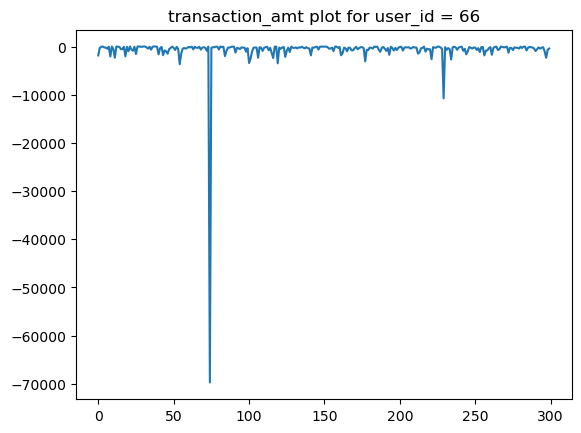

In [136]:
plt.plot(range(300), df_transactions.loc[df_transactions.user_id == 66].transaction_amt)
plt.title(f'transaction_amt plot for user_id = {66}')

In [147]:
id_for_target0 = target_attack.loc[(target_attack.target_true == 0)].user_id.values
id_for_target0

array([    66,    213,    573, ..., 868183, 868694, 868873], dtype=int64)

In [149]:
id_for_target1 = target_attack.loc[(target_attack.target_true == 1)].user_id.values
id_for_target1

array([   345,    569,   1949, ..., 867944, 868407, 868573], dtype=int64)

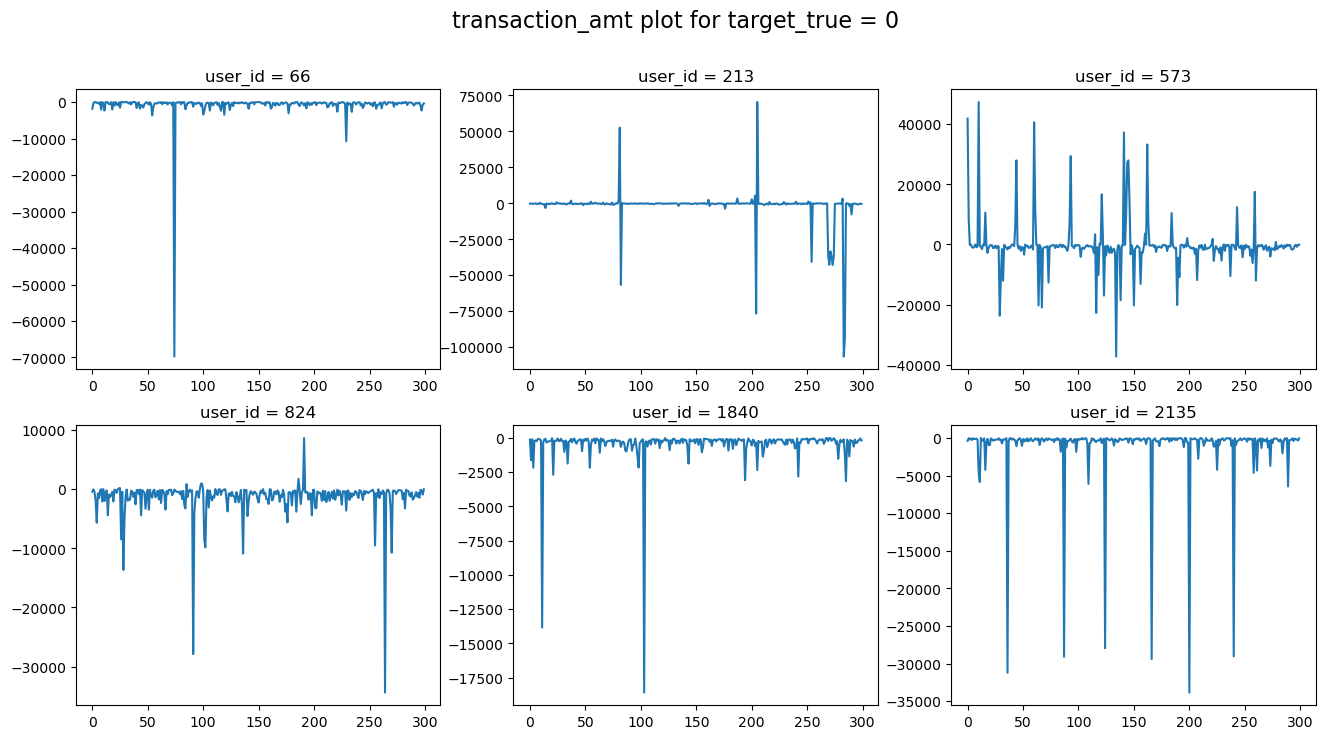

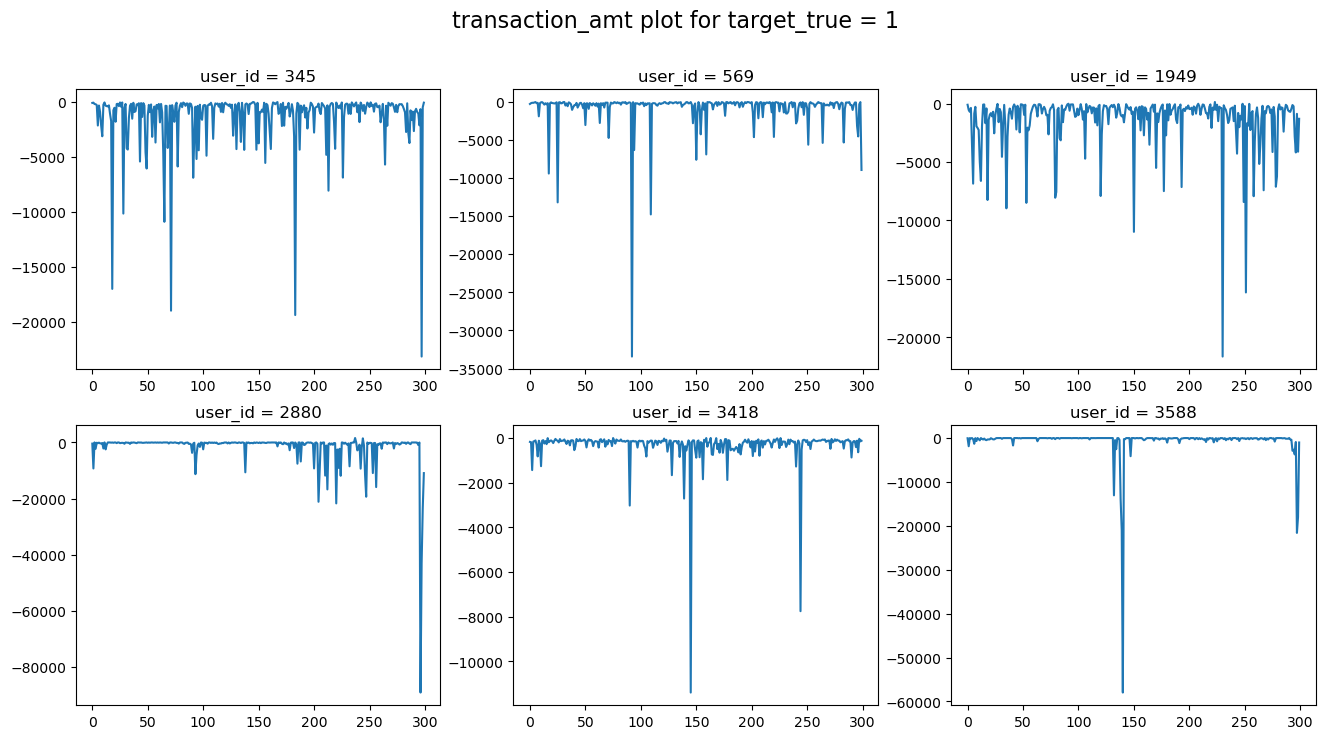

In [150]:
# график не учитывает currency_rk
fig = plt.figure(figsize=(16, 8))
fig.suptitle('transaction_amt plot for target_true = 0', fontsize=16)
for i, user_id in enumerate(id_for_target0[:6]):
    # print('shape: ', example[0].shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(range(300), df_transactions.loc[df_transactions.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')
fig = plt.figure(figsize=(16, 8))
fig.suptitle('transaction_amt plot for target_true = 1', fontsize=16)
for i, user_id in enumerate(id_for_target1[:6]):
    # print('shape: ', example[0].shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(range(300), df_transactions.loc[df_transactions.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')

Text(0.5, 1.0, 'transaction_amt plot for hero_user')

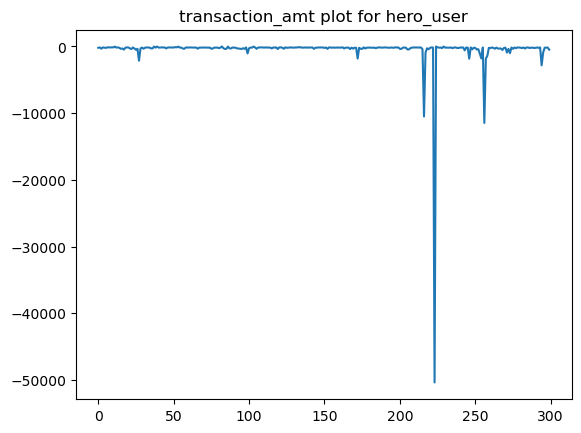

In [177]:
plt.plot(range(300), df_transactions.loc[df_transactions.user_id == hero_user].transaction_amt)
plt.title('transaction_amt plot for hero_user')

Text(0.5, 1.0, 'transaction_amt plot for poor_user')

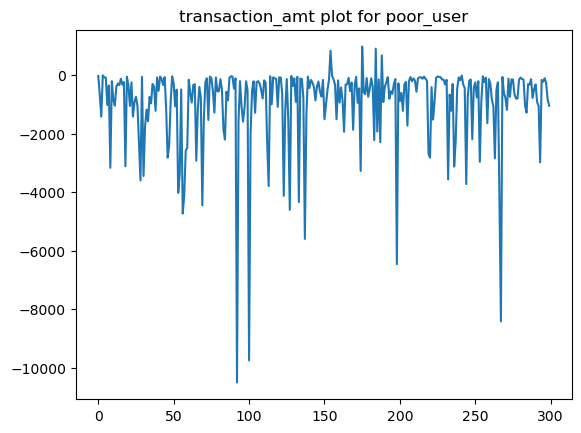

In [179]:
plt.plot(range(300), df_transactions.loc[df_transactions.user_id == poor_user].transaction_amt)
plt.title('transaction_amt plot for poor_user')

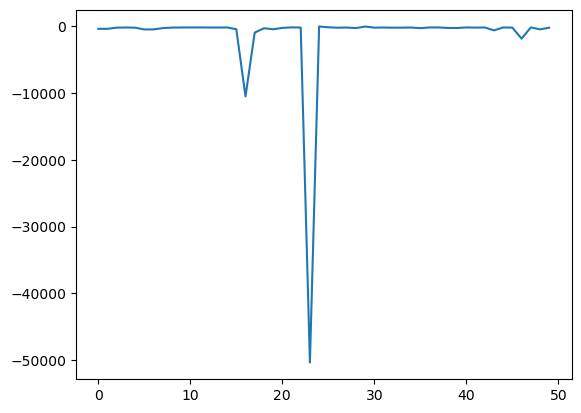

In [196]:
# "долговая яма у героя"
plt.plot(range(250-200), df_transactions.loc[df_transactions.user_id == hero_user].transaction_amt.values[200:250])

In [247]:
# Найдем топ 10 "героических" пользователей (максимальная оценка предсказания)
heroes_users = result.sort_values('target')[-10:].user_id.values
heroes_users

array([848321, 394016,  77646, 403273, 499834, 539057, 241977, 391362,
       485544, 829187], dtype=int64)

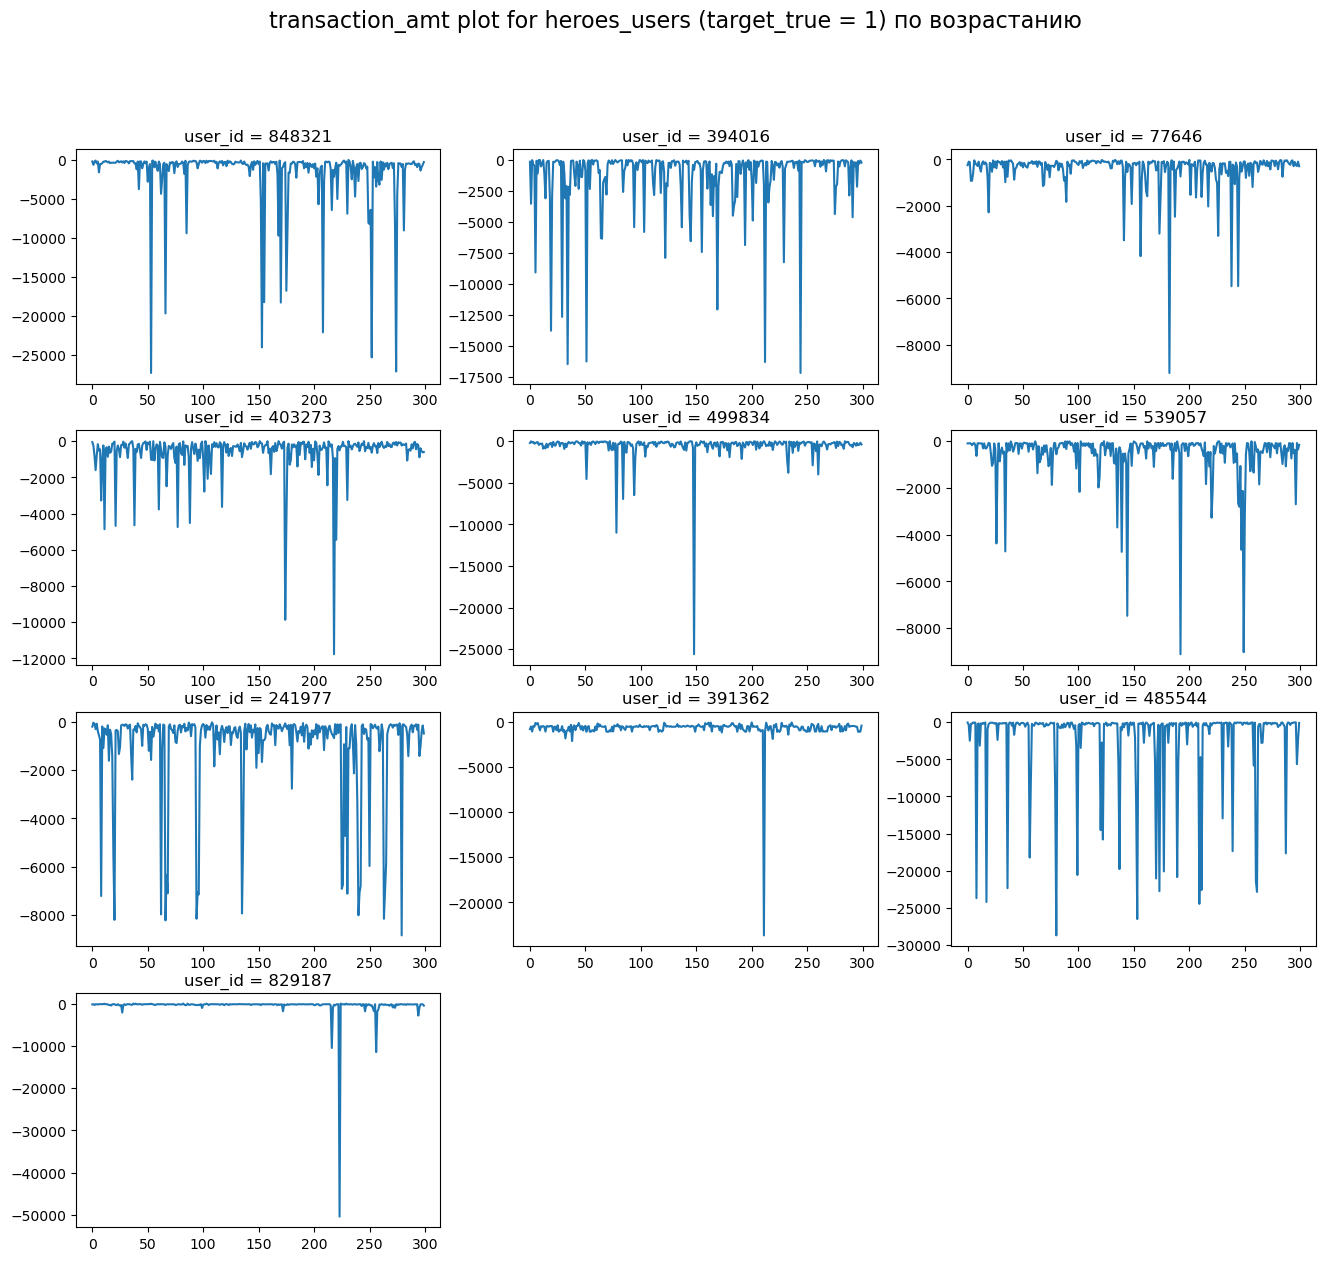

In [257]:
# график не учитывает currency_rk
fig = plt.figure(figsize=(16, 14))
fig.suptitle('transaction_amt plot for heroes_users (target_true = 1) по возрастанию', fontsize=16)
for i, user_id in enumerate(heroes_users):
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot(range(300), df_transactions.loc[df_transactions.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')

In [255]:
# Найдем топ 10 "неудачных" пользователей (минимальная оценка предсказания)
poors_users = result.sort_values('target')[:10].user_id.values
poors_users

array([488752, 576925, 817150, 447332, 233068, 571931, 109558,  46596,
       276323, 413039], dtype=int64)

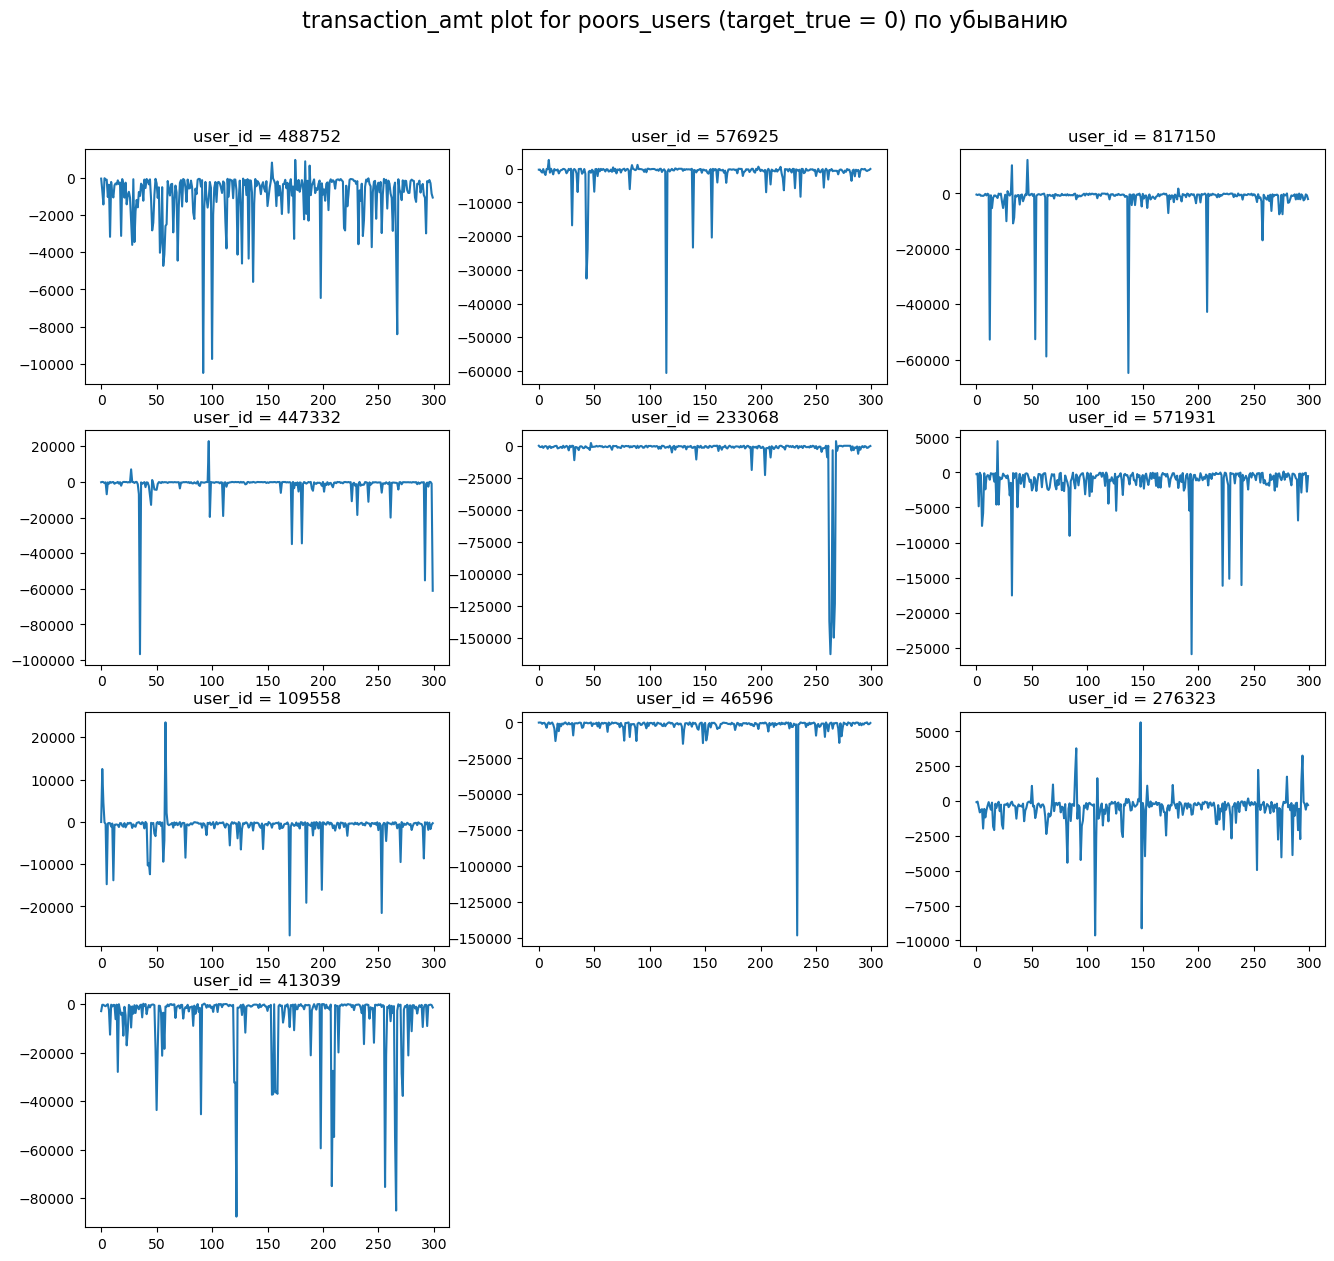

In [260]:
# график не учитывает currency_rk
fig = plt.figure(figsize=(16, 14))
fig.suptitle('transaction_amt plot for poors_users (target_true = 0) по убыванию', fontsize=16)
for i, user_id in enumerate(poors_users):
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot(range(300), df_transactions.loc[df_transactions.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')

In [277]:
# все транзакции у героев имеют currency_rk = 48
df_transactions[df_transactions.user_id.isin(heroes_users)].currency_rk.value_counts()

48    3000
Name: currency_rk, dtype: int64

In [278]:
# все транзакции у неудачников имеют currency_rk = 48
df_transactions[df_transactions.user_id.isin(poors_users)].currency_rk.value_counts()

48    3000
Name: currency_rk, dtype: int64

In [286]:
df_transactions[df_transactions.user_id == hero_user].transaction_amt.describe()

count      300.000000
mean      -509.519837
std       3033.240656
min     -50373.766000
25%       -281.978367
50%       -182.655220
75%       -161.959977
max        -11.709374
Name: transaction_amt, dtype: float64

In [333]:
# describe по героям
df_transactions[df_transactions.user_id.isin(heroes_users)].groupby(['user_id']).transaction_amt.describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
77646,300.0,-415.945650,846.227946,-9223.663,-354.470450,-182.826875,-96.957237,-21.574171
241977,300.0,-950.479579,1876.273156,-8857.308,-663.843425,-312.456650,-139.420875,-10.784763
391362,300.0,-700.313619,1366.026286,-23659.416,-916.701705,-529.969475,-456.998495,-47.502743
394016,300.0,-1239.864324,2636.883039,-17167.205,-1036.647350,-220.386130,-96.288017,-13.698133
403273,300.0,-617.190509,1196.711162,-11765.878,-553.949843,-306.896200,-149.956785,-2.755623
485544,300.0,-2019.025989,5438.612494,-28710.156,-481.890365,-197.845780,-94.432648,-18.711470
499834,300.0,-578.860504,1743.016743,-25610.902,-523.090285,-247.394430,-130.407565,-3.212798
539057,300.0,-560.006039,1088.248496,-9113.960,-532.408187,-219.231950,-106.818777,-10.681076
829187,300.0,-509.519837,3033.240656,-50373.766,-281.978367,-182.655220,-161.959977,-11.709374


In [335]:
# describe по неудачникам
df_transactions[df_transactions.user_id.isin(poors_users)].groupby(['user_id']).transaction_amt.describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
46596,300.0,-2215.662516,8826.030600,-148203.360,-1874.200600,-855.772580,-404.638755,-1.802138
109558,300.0,-1111.494597,3477.778495,-26846.180,-833.416028,-440.547200,-242.277952,23522.627000
233068,300.0,-3593.689238,18241.645685,-162462.270,-1545.451175,-827.726925,-299.659060,3525.054200
276323,300.0,-546.603399,1214.278191,-9644.793,-645.542587,-303.920060,-156.493008,5640.860000
413039,300.0,-5206.619044,12960.284400,-87566.340,-2285.912850,-818.426600,-337.299107,186.799620
447332,300.0,-1918.181876,8282.437153,-96686.640,-849.791350,-317.079730,-161.997283,22838.086000
488752,300.0,-948.357468,1403.925366,-10499.438,-1068.319800,-452.660600,-160.651348,971.935200
571931,300.0,-1269.473463,2595.801849,-25944.094,-1307.209950,-619.052270,-205.255882,4472.924000
576925,300.0,-1274.415405,4713.889579,-60597.113,-802.069123,-377.720020,-140.340455,2587.680200


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
### Check features for train data (known target value)

In [337]:
df_train = pd.read_csv(train_data_path)
df_target_train = pd.read_csv(train_target_path)

In [338]:
df_train

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,69,5541,48,-342.89792,2021-03-05 02:52:36
1,69,5533,48,-1251.88120,2021-03-05 09:43:28
2,69,5331,48,-87.30924,2021-03-05 11:17:23
3,69,5921,48,-1822.17700,2021-03-05 13:41:03
4,69,5311,48,-427.12363,2021-03-05 19:14:23
...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44


In [341]:
df_train = df_train.merge(df_target_train, how='left', on='user_id')
df_train

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target
0,69,5541,48,-342.89792,2021-03-05 02:52:36,0
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,0
2,69,5331,48,-87.30924,2021-03-05 11:17:23,0
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,0
4,69,5311,48,-427.12363,2021-03-05 19:14:23,0
...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,0
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,0
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,0
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,0


In [350]:
result_train = predict(train_data_path, bins_path, model_path, random_seed=10032023)
result_train = result_train.rename(columns={"target": "target_pred"})
result_train

Global seed set to 10032023


,user_id,target_pred
0,69,0.010340
1,140,0.088692
2,196,0.034654
3,400,0.008518
4,544,0.057525
...,...,...
7075,868342,0.035180
7076,868348,0.073727
7077,868626,0.224456
7078,868878,0.004817


In [351]:
df_train = df_train.merge(result_train, how='left', on='user_id')
df_train

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,target_pred
0,69,5541,48,-342.89792,2021-03-05 02:52:36,0,0.010340
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,0,0.010340
2,69,5331,48,-87.30924,2021-03-05 11:17:23,0,0.010340
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,0,0.010340
4,69,5311,48,-427.12363,2021-03-05 19:14:23,0,0.010340
...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,0,0.122579
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,0,0.122579
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,0,0.122579
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,0,0.122579


In [352]:
# roc auc для тренировочного набора (не участвовал в реальном трейне)
roc_auc_score(df_train.target, df_train.target_pred)

0.6785232847939558

In [362]:
id_for_train_target0 = df_train.loc[(df_train.target == 0)].user_id.unique()
id_for_train_target0

array([    69,    140,    196, ..., 868626, 868878, 868949], dtype=int64)

In [363]:
id_for_train_target1 = df_train.loc[(df_train.target == 1)].user_id.unique()
id_for_train_target1

array([  6727,   9058,   9678,  12280,  13369,  14388,  17326,  17842,
        22882,  28618,  35786,  39285,  43296,  46689,  47265,  56279,
        58718,  62354,  63756,  64825,  68380,  72245,  72712,  74514,
        78506,  79852,  82525,  84611,  93942,  94657, 101998, 103781,
       104250, 116824, 125379, 129439, 136240, 138938, 142413, 142594,
       143217, 144471, 145785, 150823, 155164, 158929, 159479, 162285,
       162362, 163330, 168080, 175997, 180493, 184981, 186780, 188516,
       189780, 191356, 195086, 197255, 197396, 201280, 215248, 216042,
       217254, 224495, 232358, 235018, 236494, 239542, 241418, 242015,
       245274, 247052, 264288, 265500, 267040, 269862, 274308, 274763,
       274854, 275730, 280369, 282657, 286423, 288260, 288341, 291830,
       292785, 296241, 296361, 301932, 304441, 311382, 319330, 324281,
       327295, 332001, 333890, 334101, 340833, 347708, 351773, 351990,
       352477, 359293, 360883, 365734, 371757, 373868, 374900, 375157,
      

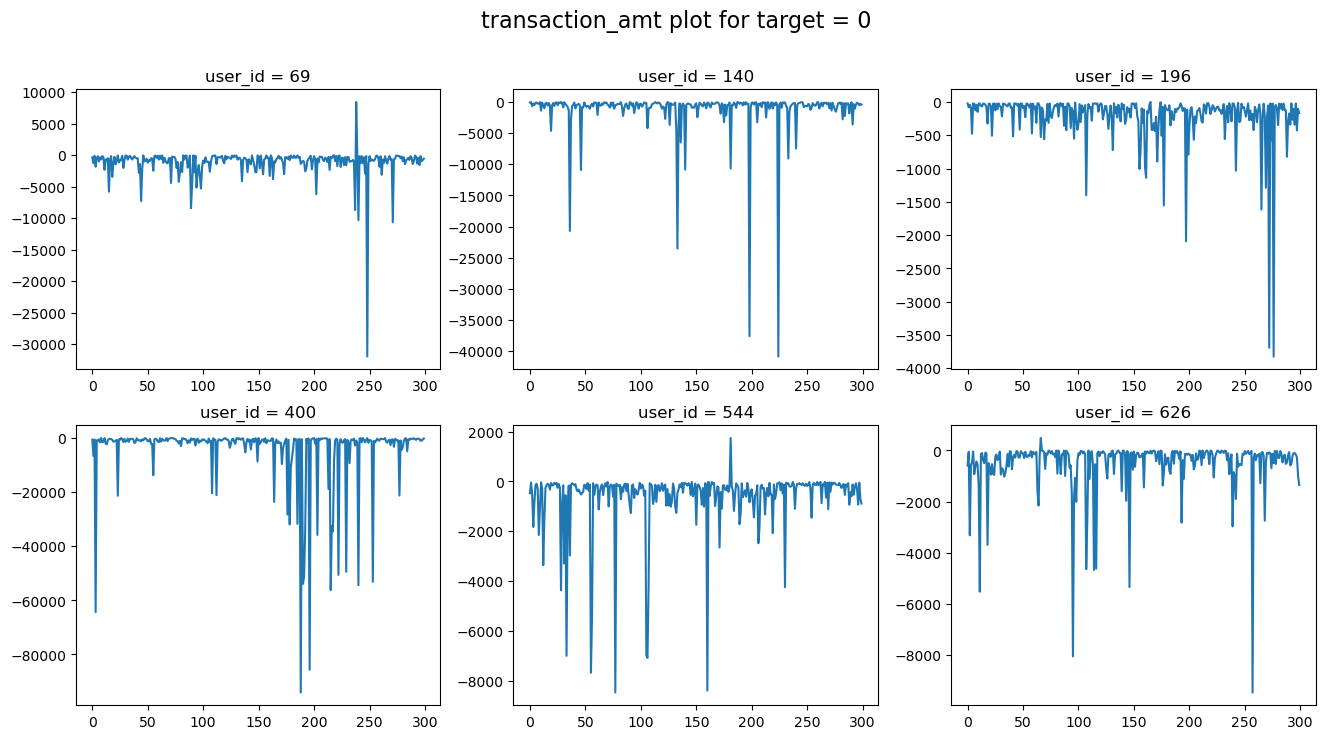

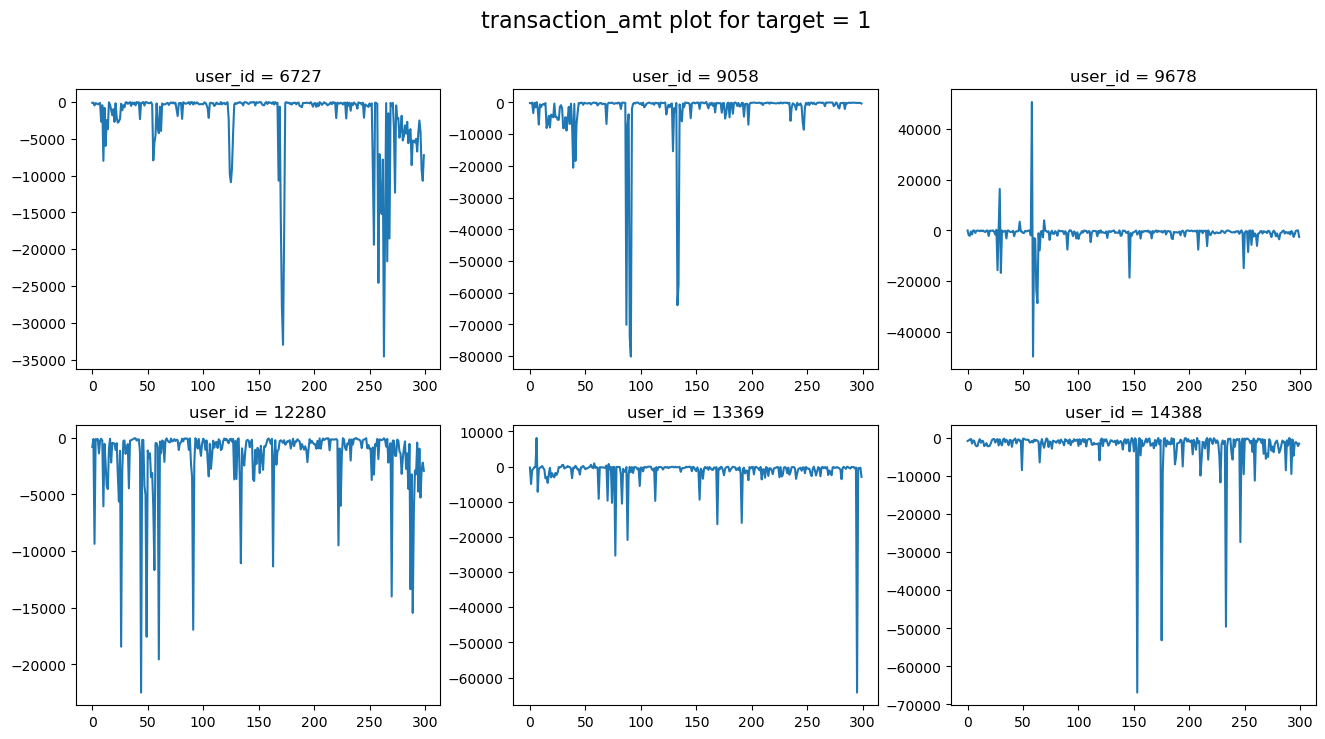

In [369]:
# график не учитывает currency_rk
fig = plt.figure(figsize=(16, 8))
fig.suptitle('transaction_amt plot for target = 0', fontsize=16)
for i, user_id in enumerate(id_for_train_target0[:6]):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(range(300), df_train.loc[df_train.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')
fig = plt.figure(figsize=(16, 8))
fig.suptitle('transaction_amt plot for target = 1', fontsize=16)
for i, user_id in enumerate(id_for_train_target1[:6]):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(range(300), df_train.loc[df_train.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')

In [365]:
# Найдем топ 10 "героических" пользователей для трейна (максимальная оценка предсказания)
heroes_users_train = result_train.sort_values('target_pred')[-10:].user_id.values
heroes_users_train

array([228615,  43296, 239542, 104786, 802373, 464184,    626, 720314,
       274763, 469439], dtype=int64)

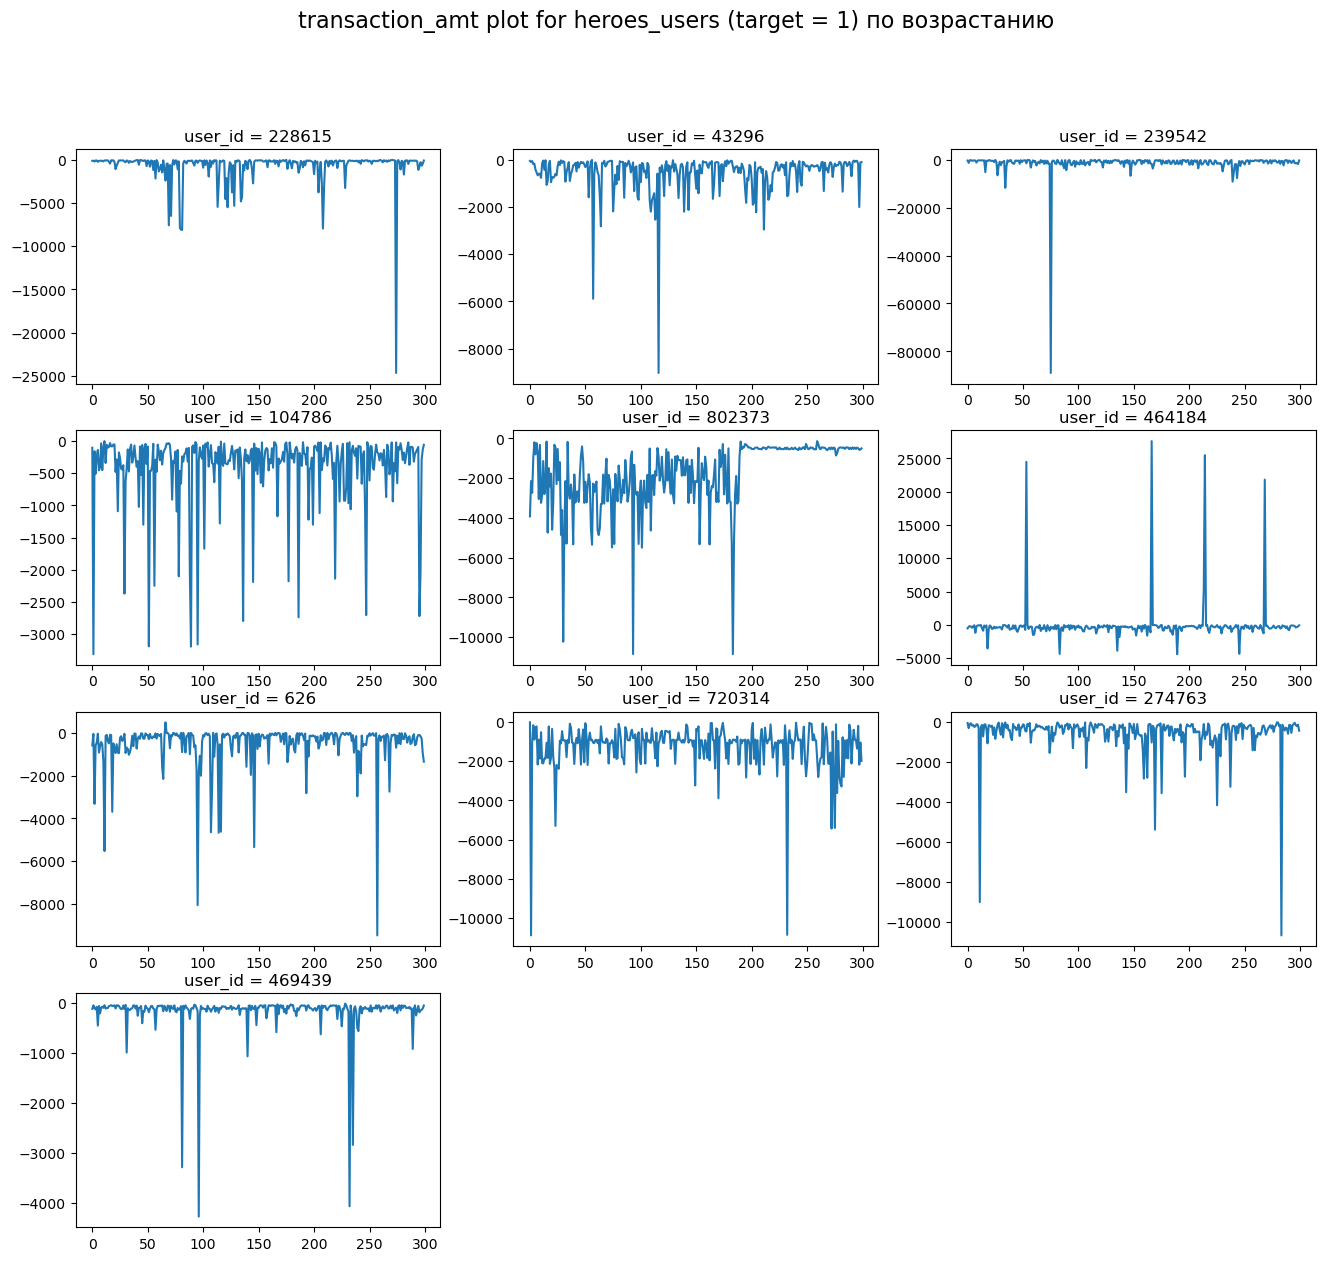

In [374]:
# график не учитывает currency_rk
fig = plt.figure(figsize=(16, 14))
fig.suptitle('transaction_amt plot for heroes_users (target = 1) по возрастанию', fontsize=16)
for i, user_id in enumerate(heroes_users_train):
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot(range(300), df_train.loc[df_train.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')

In [373]:
# Найдем топ 10 "неудачных" пользователей (минимальная оценка предсказания)
poors_users_train = result_train.sort_values('target_pred')[:10].user_id.values
poors_users_train

array([249063, 388082, 134022, 346730, 617721, 367873, 309360,  53300,
       531280, 352665], dtype=int64)

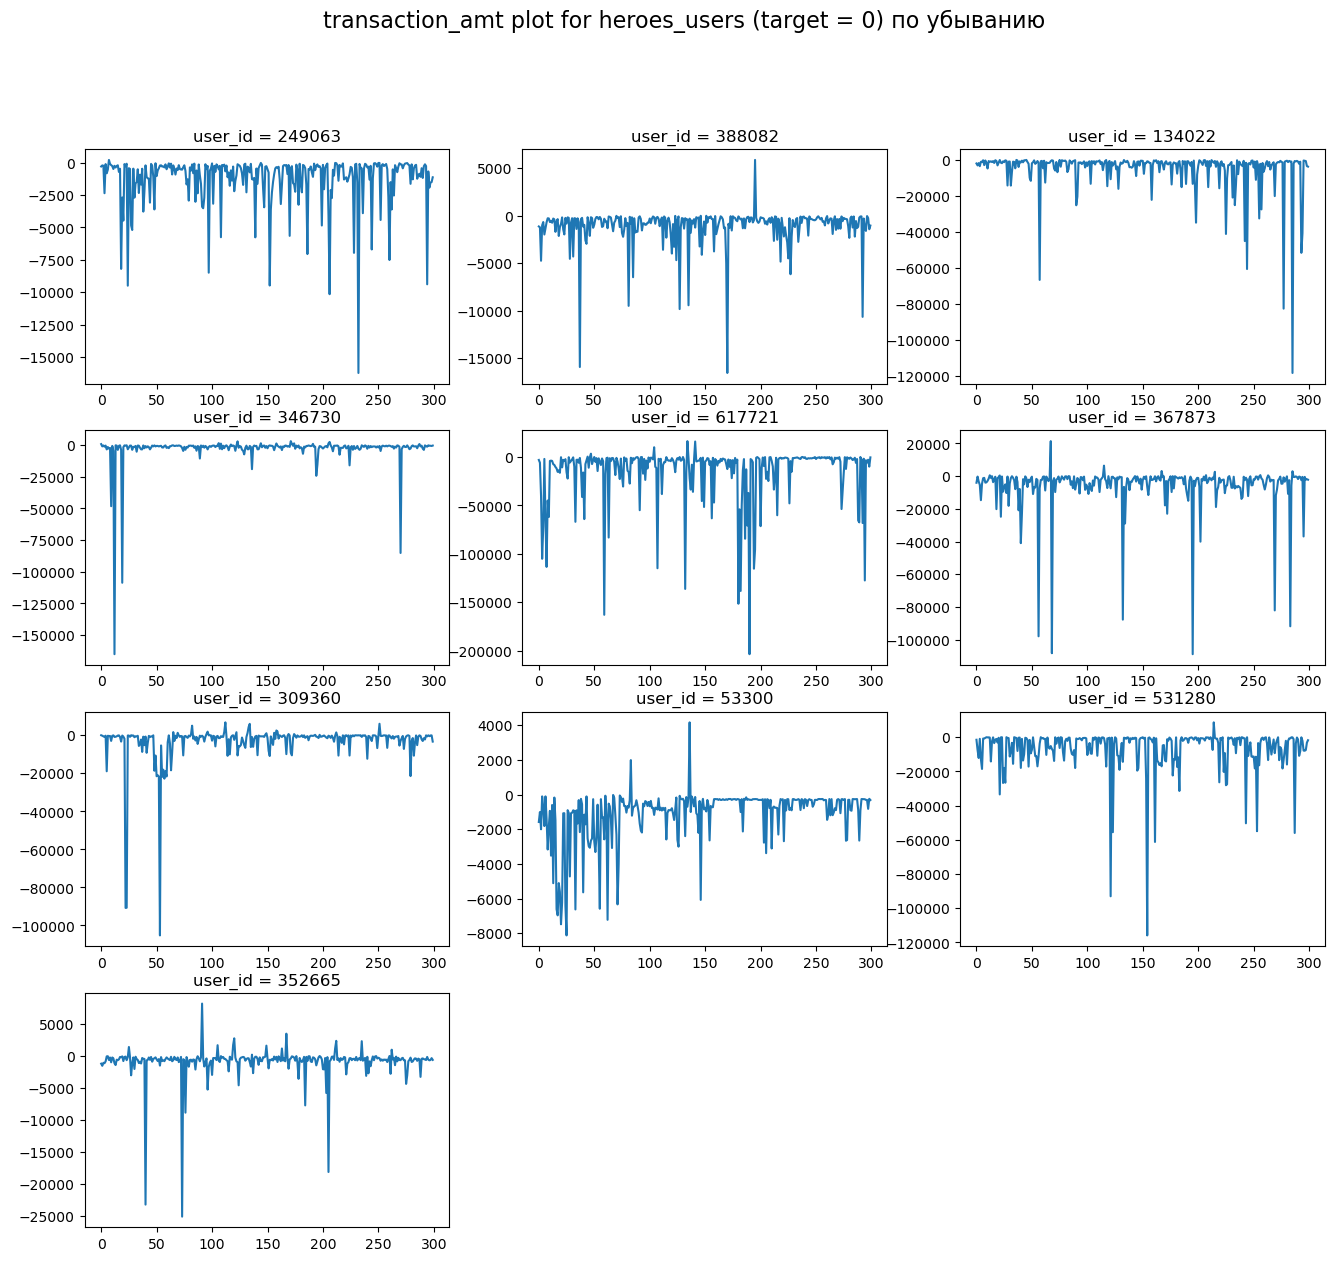

In [375]:
# график не учитывает currency_rk
fig = plt.figure(figsize=(16, 14))
fig.suptitle('transaction_amt plot for heroes_users (target = 0) по убыванию', fontsize=16)
for i, user_id in enumerate(poors_users_train):
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot(range(300), df_train.loc[df_train.user_id == user_id].transaction_amt)
    ax.set_title(f'user_id = {user_id}')

In [376]:
# все транзакции у героев имеют currency_rk = 48
df_train[df_train.user_id.isin(heroes_users_train)].currency_rk.value_counts()

48    3000
Name: currency_rk, dtype: int64

In [377]:
# все транзакции у неудачников имеют currency_rk = 48
df_train[df_train.user_id.isin(poors_users_train)].currency_rk.value_counts()

48    3000
Name: currency_rk, dtype: int64

In [490]:
###############################################
# testing df_train last 10
##############################################
hero_user_train = result_train.user_id.loc[result_train.target_pred.argmax()]
print(hero_user_train)
poor_user_train = result_train.user_id.loc[result_train.target_pred.argmin()]
print(poor_user_train)

random.seed(10032023)

# threshold = pd.read_csv("../data/target_finetune.csv").target.mean()  # вероятность, по которой мы считаем таргет

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)

bins_path = "nn_bins.pickle"
model_path = "nn_weights.ckpt"
target = predict(transactions_path, bins_path, model_path)

one_idx = target.index[target.target > threshold_train]  # Эти пользователи похожи на Героя
zero_idx = target.index[target.target <= threshold_train] # А эти на Неудачника

users = target.user_id.values

one_users = users[one_idx] # defolt - 1
zero_users = users[zero_idx] # norm users - 0

for user in tqdm(users):
    if user in one_users:
        copy_from = poor_user_train # похожим на Героя скопируем 10 последних транзакций Неудачника
    else:
        copy_from = hero_user_train # А похожим на Неудачника наоборот

    idx_to = df_transactions.index[df_transactions.user_id == user][-BUDGET:] # айдишники последних 10 транзакций юзера
    idx_from = df_train.index[df_train.user_id == copy_from][-BUDGET:] # айдишники последних 10 транзакций воннаби

    sign_to = np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)
    sign_from = np.sign(df_transactions.loc[idx_from, "transaction_amt"].values)
    sign_mask = (sign_to == sign_from)

    df_transactions.loc[idx_to[sign_mask], "mcc_code"] = df_train.loc[idx_from[sign_mask], "mcc_code"].values
    df_transactions.loc[idx_to[sign_mask], "transaction_amt"] = df_train.loc[idx_from[sign_mask], "transaction_amt"].values
df_transactions.to_csv(output_path, index=False)

469439
249063


Global seed set to 20230206
100%|█████████████████████████████████████████████████████████████████████████████| 4200/4200 [00:18<00:00, 221.91it/s]


In [421]:
check_budget(transactions_path, output_path, quantiles_path)

100%|█████████████████████████████████████████████████████████████████████| 1260000/1260000 [00:34<00:00, 36376.40it/s]


True

In [491]:
target_attack = roc_auc_diff(output_path, transactions_path, threshold=threshold_train)

Global seed set to 10032023
Global seed set to 10032023


ROC-AUC original 1.0
ROC-AUC attacked 0.9288619875615604
DIF ROC-AUC 0.07113801243843965


In [413]:
np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [414]:
np.sign(df_train.loc[idx_from, "transaction_amt"].values)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [417]:
(sign_to == sign_from)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [418]:
df_train.loc[idx_from[(sign_to == sign_from)], "mcc_code"].values

array([5921, 5411, 5411, 5411, 5411, 5411, 5921, 5921, 5411, 5411],
      dtype=int64)

In [419]:
df_train.loc[idx_from[(sign_to == sign_from)], "transaction_amt"].values

array([-119.20878,  -54.03762, -256.92007, -161.63596,  -64.85865,
       -193.73927, -155.68417, -142.90938, -116.5322 ,  -57.4111 ])

In [388]:
# target_attack = roc_auc_diff(output_path, transactions_path, threshold=threshold_train)
# threshold_train
# ods score 0.108501

Global seed set to 10032023
Global seed set to 10032023


ROC-AUC original 1.0
ROC-AUC attacked 0.7698878814588355
DIF ROC-AUC 0.23011211854116453


In [385]:
# target_attack = roc_auc_diff(output_path, transactions_path, threshold=threshold_train)
# naive basline
# ods score 0.44603

Global seed set to 10032023
Global seed set to 10032023


ROC-AUC original 1.0
ROC-AUC attacked 0.9633964706389955
DIF ROC-AUC 0.03660352936100453


In [493]:
threshold_train

0.037005649717514126

In [498]:
###############################################
# testing
##############################################
# hero_user_train = result_train.user_id.loc[result_train.target_pred.argmax()]
# hero_user
output_path = 'naive_submission_3.csv'
print(hero_user)
poor_user = 109558
print(poor_user)

random.seed(10032023)

# threshold = pd.read_csv("../data/target_finetune.csv").target.mean()  # вероятность, по которой мы считаем таргет

df_transactions = pd.read_csv(
    transactions_path,
    parse_dates=["transaction_dttm"],
    dtype={"user_id": int, "mcc_code": int, "currency_rk": int, "transaction_amt": float},
)

bins_path = "nn_bins.pickle"
model_path = "nn_weights.ckpt"
target = predict(transactions_path, bins_path, model_path)

one_idx = target.index[target.target > threshold]  # Эти пользователи похожи на Героя
zero_idx = target.index[target.target <= threshold] # А эти на Неудачника

users = target.user_id.values

one_users = users[one_idx] # defolt - 1
zero_users = users[zero_idx] # norm users - 0

for user in tqdm(users):
    if user in one_users:
        copy_from = poor_user # похожим на Героя скопируем 10 транзакций Неудачника
        idx_from = df_transactions.index[df_transactions.user_id == copy_from][-BUDGET:] # айдишники 10 транзакций
    else:
        copy_from = hero_user # А похожим на Неудачника наоборот
        idx_from = df_transactions.index[df_transactions.user_id == copy_from][-BUDGET:] # айдишники 10 транзакций воннаби

    idx_to = df_transactions.index[df_transactions.user_id == user][-BUDGET:] # айдишники последних 10 транзакций юзера
    # idx_from = df_transactions.index[df_transactions.user_id == copy_from][-BUDGET:] # айдишники последних 10 транзакций воннаби

    sign_to = np.sign(df_transactions.loc[idx_to, "transaction_amt"].values)
    sign_from = np.sign(df_transactions.loc[idx_from, "transaction_amt"].values)
    sign_mask = (sign_to == sign_from)

    df_transactions.loc[idx_to[sign_mask], "mcc_code"] = df_transactions.loc[idx_from[sign_mask], "mcc_code"].values
    df_transactions.loc[idx_to[sign_mask], "transaction_amt"] = df_transactions.loc[idx_from[sign_mask], "transaction_amt"].values
df_transactions.to_csv(output_path, index=False)
target_attack = roc_auc_diff(output_path, transactions_path, threshold=threshold_train)

829187
109558


Global seed set to 20230206
100%|█████████████████████████████████████████████████████████████████████████████| 4200/4200 [00:19<00:00, 217.96it/s]
Global seed set to 10032023
Global seed set to 10032023


ROC-AUC original 1.0
ROC-AUC attacked 0.9676519209314655
DIF ROC-AUC 0.03234807906853454


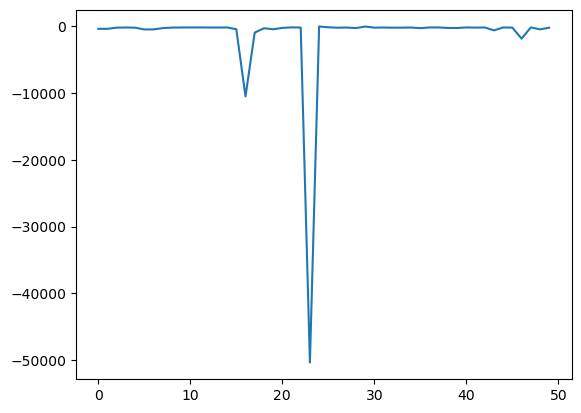

In [426]:
# "долговая яма у героя"
plt.plot(range(250-200), df_transactions.loc[df_transactions.user_id == hero_user].transaction_amt.values[200:250])

In [433]:
df_transactions.loc[df_transactions.user_id == hero_user].transaction_amt.values[214:224]

array([-4.2495532e+02, -1.0503190e+04, -9.3619290e+02, -2.7863474e+02,
       -4.2959450e+02, -2.2783601e+02, -1.5031425e+02, -1.7526208e+02,
       -5.0373766e+04, -1.3791564e+01])

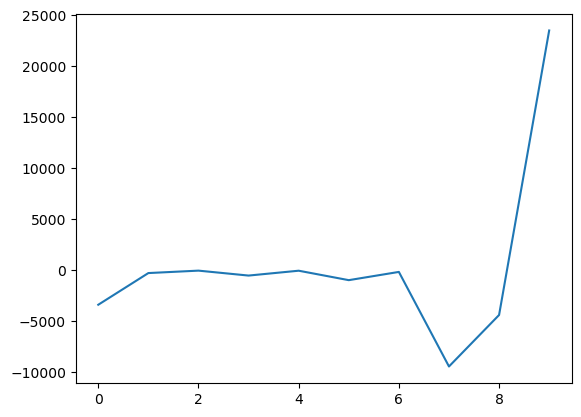

In [454]:
plt.plot(range(10), df_transactions.loc[df_transactions.user_id == 109558].transaction_amt.values[49:59])

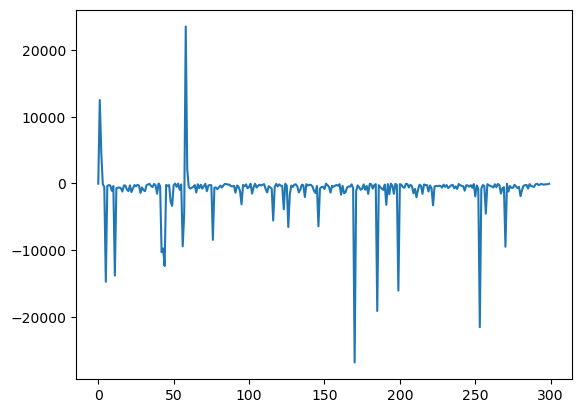

In [441]:
plt.plot(range(300), df_transactions.loc[df_transactions.user_id == 109558].transaction_amt.values[:])